In [47]:
# Cell 1 — Imports & Reproducibility
import os
import math
import random
from dataclasses import dataclass
from typing import Optional, Dict, Any, Tuple
from pathlib import Path
import mne
from scipy.signal import welch

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("Device:", DEVICE)


Device: cpu


In [48]:
%matplotlib inline

# PLOT DEF

In [49]:
def plot_psd_lh_rh(X, y, fs, fmin=1, fmax=45, nperseg=256):
    """
    X: (trials, channels, time)
    y: (trials,) 0=LH, 1=RH
    One figure with one subplot per channel (LH vs RH).
    """

    n_trials, n_ch, n_t = X.shape

    lh = np.where(y == 0)[0]
    rh = np.where(y == 1)[0]

    fig, axes = plt.subplots(n_ch, 1, figsize=(8, 3 * n_ch), sharex=True)

    if n_ch == 1:
        axes = [axes]

    for ch, ax in enumerate(axes):
        lh_psds = []
        rh_psds = []

        for i in lh:
            f, p = welch(X[i, ch], fs=fs, nperseg=nperseg)
            lh_psds.append(p)

        for i in rh:
            f, p = welch(X[i, ch], fs=fs, nperseg=nperseg)
            rh_psds.append(p)

        lh_mean = np.mean(lh_psds, axis=0)
        rh_mean = np.mean(rh_psds, axis=0)

        mask = (f >= fmin) & (f <= fmax)

        ax.semilogy(f[mask], lh_mean[mask], label="LH", linewidth=2)
        ax.semilogy(f[mask], rh_mean[mask], "--", label="RH", linewidth=2)

        # Highlight alpha & beta
        ax.axvspan(8, 12, alpha=0.15) # Alpha(mu rhythm)
        ax.axvspan(12, 30, alpha=0.1) # Beta(motor rhythm)

        ax.set_title(f"Channel {ch}")
        ax.set_ylabel("Power")

        if ch == 0:
            ax.legend()

    axes[-1].set_xlabel("Frequency (Hz)")
    fig.suptitle(f"LH vs RH PSD (Welch, nperseg={nperseg})", y=1.02)
    plt.tight_layout()
    plt.show()

In [50]:
def plot_trials(X: np.ndarray, fs: int = 250, n_show: int = 3):
    idx = np.random.choice(len(X), n_show, replace=False)
    for t in idx:
        trial = X[t]

        n_channels = trial.shape[0]
        time = np.arange(trial.shape[1]) / fs

        plt.figure(figsize=(12, 2 * n_channels))

        for ch in range(n_channels):
            plt.subplot(n_channels, 1, ch + 1)
            plt.plot(time, trial[ch])
            plt.ylabel(f"Ch {ch}")

            if ch == 0:
                plt.title(f"Trial {t}")

        plt.xlabel("Time (s)")
        plt.tight_layout()
        plt.show()

In [51]:
def print_stats_X(X: np.ndarray):
    assert X.ndim == 3, f"Expected X to be 3D (trials, channels, time). Got {X.shape}"

    print("Shape:", X.shape)
    print("NaNs:", np.isnan(X).sum())
    print("Infs:", np.isinf(X).sum())

    print("Min val:", np.nanmin(X))
    print("Max val:", np.nanmax(X))

    # Per-channel across all trials and time
    ch_std = np.nanstd(X, axis=(0, 2))        # (channels,)
    # Per-trial-per-channel over time
    trial_ch_std = np.nanstd(X, axis=2)       # (trials, channels)

    print("\nPer-channel std across (trials,time):")
    print("Min:", ch_std.min())
    print("Median:", np.median(ch_std))
    print("Max:", ch_std.max())
    print("Channels with std < 1e-7:", np.sum(ch_std < 1e-7))
    print("Channels with std < 1e-8:", np.sum(ch_std < 1e-8))

    print("\nPer-trial-per-channel std over time:")
    print("Min:", trial_ch_std.min())
    print("Median:", np.median(trial_ch_std))
    print("Max:", trial_ch_std.max())

    # Per-channel across all trials and time
    ch_mean = np.nanmean(X, axis=(0, 2))      # (channels,)
    # Per-trial-per-channel over time
    trial_ch_mean = np.nanmean(X, axis=2)     # (trials, channels)

    print("\nPer-channel mean across (trials,time):")
    print("Min:", ch_mean.min())
    print("Median:", np.median(ch_mean))
    print("Max:", ch_mean.max())

    print("\nPer-trial-per-channel mean over time:")
    print("Min:", trial_ch_mean.min())
    print("Median:", np.median(trial_ch_mean))
    print("Max:", trial_ch_mean.max())

In [52]:
def plot_psd_welch(X, fs, fmin=1, fmax=45, nperseg=None, n_show_channels=None):
    """
    X: (trials, channels, time)
    Plots mean PSD per channel (averaged over trials).
    """
    n_trials, n_ch, n_t = X.shape
    if nperseg is None:
        nperseg = min(256, n_t)

    ch_list = range(n_ch) if n_show_channels is None else range(min(n_show_channels, n_ch))

    plt.figure(figsize=(10, 6))
    for ch in ch_list:
        # PSD per trial then average
        psds = []
        for i in range(n_trials):
            f, pxx = welch(X[i, ch], fs=fs, nperseg=nperseg)
            psds.append(pxx)
        psd_mean = np.mean(psds, axis=0)

        # crop freq
        mask = (f >= fmin) & (f <= fmax)
        plt.semilogy(f[mask], psd_mean[mask], label=f"Ch {ch}")
                # Highlight alpha & beta
        plt.axvspan(8, 12, alpha=0.15) # Alpha(mu rhythm)
        plt.axvspan(12, 30, alpha=0.1) # Beta(motor rhythm)

    plt.title("Welch PSD (mean across trials)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [53]:
def plot_temporal_autocorr(X, fs, max_lag_ms=500, n_trials_use=200, title="Temporal autocorrelation", show=True):
    """
    Mean autocorrelation for ALL channels on one canvas.
    X: (trials, channels, time)
    Returns: fig, axes
    """
    n_trials, n_ch, _ = X.shape
    idx = np.random.choice(n_trials, min(n_trials_use, n_trials), replace=False)

    max_lag = int((max_lag_ms/1000)*fs)

    def autocorr(x):
        x = x - x.mean()
        denom = np.dot(x, x) + 1e-12
        return np.array([np.dot(x[:-k], x[k:]) / denom for k in range(1, max_lag+1)])

    lags = np.arange(1, max_lag+1) / fs * 1000

    fig, axes = plt.subplots(n_ch, 1, figsize=(6, 3*n_ch), sharex=True)

    if n_ch == 1:
        axes = [axes]

    for ch, ax in enumerate(axes):
        acs = []
        for i in idx:
            acs.append(autocorr(X[i, ch]))

        ac_mean = np.mean(acs, axis=0)

        ax.plot(lags, ac_mean)
        ax.set_title(f"Channel {ch}")
        ax.set_ylabel("Autocorr")
        ax.axhline(0, color="gray", linewidth=0.5)

    axes[-1].set_xlabel("Lag (ms)")
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    
    if show:
        plt.show()
    
    return fig, axes

In [54]:
def plot_channel_correlation(X):
    flat = X.transpose(1, 0, 2).reshape(X.shape[1], -1)
    corr = np.corrcoef(flat)

    n_ch = corr.shape[0]

    plt.figure(figsize=(4,4))
    plt.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(label="Correlation")

    # 🔴 Force integer ticks
    plt.xticks(range(n_ch), range(n_ch))
    plt.yticks(range(n_ch), range(n_ch))

    plt.title("Channel correlation matrix")
    plt.xlabel("Channel")
    plt.ylabel("Channel")

    plt.tight_layout()
    plt.show()

    print("Correlation matrix:\n", corr)

In [55]:
def bandpower(sig, fs, band, nperseg=256):
    f, pxx = welch(sig, fs=fs, nperseg=nperseg)
    lo, hi = band
    mask = (f >= lo) & (f <= hi)
    return np.trapz(pxx[mask], f[mask])


def compute_bandpowers(X, fs, bands, nperseg=256):
    """
    returns: dict band -> array (trials, channels)
    """
    n_trials, n_ch, _ = X.shape
    out = {}

    for name, band in bands.items():
        bp = np.zeros((n_trials, n_ch))
        for i in range(n_trials):
            for ch in range(n_ch):
                bp[i, ch] = bandpower(X[i, ch], fs, band, nperseg)
        out[name] = bp

    return out

In [56]:
def cohens_d(a, b):
    na, nb = len(a), len(b)
    sa, sb = np.var(a, ddof=1), np.var(b, ddof=1)
    pooled = np.sqrt(((na-1)*sa + (nb-1)*sb) / (na+nb-2))
    return (np.mean(a) - np.mean(b)) / pooled


def compute_effect_sizes(bp, y):
    """
    prints Cohen's d per band per channel
    """
    for band in bp:
        print(f"\n{band.upper()} BAND:")
        for ch in range(bp[band].shape[1]):
            lh = bp[band][y == 0, ch]
            rh = bp[band][y == 1, ch]

            d = cohens_d(lh, rh)
            print(f"Channel {ch}: d = {d:.3f}")

In [57]:
def plot_bandpower_boxplots(bp, y, band):
    n_ch = bp[band].shape[1]

    fig, axes = plt.subplots(1, n_ch, figsize=(4*n_ch, 4), sharey=True)

    if n_ch == 1:
        axes = [axes]

    for ch, ax in enumerate(axes):
        lh = bp[band][y == 0, ch]
        rh = bp[band][y == 1, ch]

        ax.boxplot([lh, rh], tick_labels=["LH", "RH"], showfliers=False)
        ax.set_yscale("log")   # 🔴 IMPORTANT
        ax.set_title(f"{band.capitalize()} — Ch {ch}")
        ax.set_ylabel("Bandpower (log)")

    plt.suptitle(f"{band.capitalize()} bandpower LH vs RH (log scale)")
    plt.tight_layout()
    plt.show()

In [58]:
def plot_hist_per_channel(X, bins=100):
    """
    Flattens trials+time and plots amplitude histograms per channel.
    """
    n_trials, n_ch, n_t = X.shape

    fig, axes = plt.subplots(1, n_ch, figsize=(4*n_ch, 4), sharey=True)

    if n_ch == 1:
        axes = [axes]

    for ch, ax in enumerate(axes):
        vals = X[:, ch, :].reshape(-1)

        ax.hist(vals, bins=bins, density=True, alpha=0.8)
        ax.set_title(f"Channel {ch}")
        ax.set_xlabel("Amplitude")
        ax.set_ylabel("Density")

    plt.suptitle("Amplitude histogram per channel")
    plt.tight_layout()
    plt.show()

------

# Data Function

In [59]:
def split_runs(raw: mne.io.BaseRaw, separate_event: str) -> list[mne.io.BaseRaw]:
    events, event_id = mne.events_from_annotations(raw)

    if separate_event in event_id:
        run_code = event_id[separate_event]
    else:
        # sometimes MNE stores slightly different strings; try fallback:
        candidates = [k for k in event_id.keys() if separate_event in k]
        if not candidates:
            raise RuntimeError(f"No run marker {separate_event} found. event_id keys={list(event_id.keys())[:20]} ...")
        run_code = event_id[candidates[0]]

    run_starts = np.sort(events[events[:, 2] == run_code, 0])  # sample indices
    sf = raw.info["sfreq"]

    runs = []
    for i, start in enumerate(run_starts):
        end = run_starts[i + 1] if i + 1 < len(run_starts) else raw.n_times
        run = raw.copy().crop(tmin=start / sf, tmax=(end - 1) / sf, include_tmax=True)
        runs.append(run)

    return runs

In [60]:
def load_gdf_file(file_path: str, picks: list[int] | None = None, resample_hz: int | None = None, verbose: bool = False) -> mne.io.BaseRaw:
    """Load a single .gdf file, pick EEG channels, and resample."""
    raw = mne.io.read_raw_gdf(file_path, preload=True, verbose="error")
    if verbose:
        print(f"==== Loaded {raw.filenames[0].name}: {len(raw.ch_names)} channels, {raw.n_times} samples at {raw.info['sfreq']} Hz =====")
        
    for name in raw.info["ch_names"]:
        if "eog" in name.lower():
            raw.set_channel_types({name: "eog"})
            
            if verbose:
                print(f"File: {raw.filenames[0].name}, Channels: {name}) set to eog")
            
    if picks is not None:
        raw.pick(picks)  # Keep only specified channels
    if resample_hz is not None:
        raw.resample(resample_hz)
        
    if verbose:
        print(f"Channels: {raw.ch_names}")
        print(f"Channel types: {raw.get_channel_types()}")
        print(f"================================================================")
        print()
        
    return raw

In [61]:
def load_gdf_files(data_dir: Path, picks: list[int] | None, resample_hz: int | None, mode: str, verbose: bool = False)  -> list[mne.io.BaseRaw]:
    if mode == "train":
        pattern = "*T.gdf"  # Training files
    elif mode == "eval":
        pattern = "*E.gdf"  # Evaluation files
    else:
        raise ValueError("mode should be 'train' or 'eval'")
    
    all_files = sorted([file for file in data_dir.glob(pattern)])
    
    if len(all_files) == 0:
        raise ValueError(f"No .gdf files found in {data_dir} with pattern {pattern}")
    
    raws = []   
    for file in all_files:
        raw = load_gdf_file(file, picks=picks, resample_hz=resample_hz, verbose=verbose)
        raws.append(raw)
    
    return raws

In [62]:
def remove_artifacts(raw: mne.io.BaseRaw, verbose: bool = False) -> mne.io.BaseRaw:
    """Remove EOG artifacts using thresholding."""
    raw = raw.copy() # avoid modifying original data
    
    eog_channels = mne.pick_types(raw.info, eog=True)
    eeg_channels = mne.pick_types(raw.info, eeg=True)
    
    if verbose:
        print(f"EEG channels: {[raw.ch_names[i] for i in eeg_channels]}")
        print(f"EOG channels: {[raw.ch_names[i] for i in eog_channels]}")
    
    if len(eog_channels) == 0:
        if verbose:
            print("No EOG channels found for artifact removal.")
        return raw

    eog_data = raw.get_data(picks=eog_channels)
    eeg_data = raw.get_data(picks=eeg_channels)
    
    # Add intercept to EOG
    num_samples = eog_data.shape[1] # eog_data shape: (n_channels, n_samples)
    bias_term = np.ones((1, num_samples))
    X = np.vstack([eog_data, bias_term]).T # shape (n_samples, n_eog+1)
    
    # Solve for each EEG channel: eeg_ch ≈ X @ beta
    betas = np.linalg.lstsq(X, eeg_data.T, rcond=None)[0]  # shape (n_eog+1, n_eeg)
    eeg_hat = (X @ betas).T # predicted EOG contribution to EEG, shape (n_eeg, n_samples)
     
    # subtract
    raw.apply_function(lambda data: data - eeg_hat, picks=eeg_channels, channel_wise=False)

    return raw, eeg_hat

In [63]:
def create_epoch(raw: mne.io.Raw, code_map: Dict[str, int], tmin: float, tmax: float) -> Optional[mne.Epochs]:
    for name in raw.info["ch_names"]:
        if "eeg" not in name.lower():
            print(f"Warning: Channel '{name}' dose not have 'EEG'. Check if channel picking is correct.")
            
    events, event_dict = mne.events_from_annotations(raw, verbose="error")
    
    # Convert GDF numeric codes -> annotation keys (strings like "769")
    lh_key = str(code_map.get("LH", ""))
    rh_key = str(code_map.get("RH", ""))
    bad_key = str(code_map.get("bad", "")) if "bad" in code_map else None

    lh_id = event_dict.get(lh_key)
    rh_id = event_dict.get(rh_key)

    if lh_id is None or rh_id is None:
        fname = raw.filenames[0] if raw.filenames else "<unknown>"
        print(f"[{fname}] Missing LH/RH in annotations. Need keys {lh_key}, {rh_key}. Available: {list(event_dict.keys())}")
        return None
    
     # Optionally exclude rejected trials (1023)
    if bad_key is not None:
        bad_id = event_dict.get(bad_key)
        if bad_id is not None:
            events = events[events[:, 2] != bad_id]

    picked = {"LH": lh_id, "RH": rh_id}
    print(f"event_dict keys sample: {list(event_dict.keys())[:10]}")
    print(f"mapped event_id: {picked}")
    
    epochs = mne.Epochs(raw, events, event_id=picked, tmin=tmin, tmax=tmax, baseline=None, preload=True, verbose="error")
    
    return epochs

In [64]:
def make_dataset(raws: list[mne.io.Raw], tmin: float, tmax: float, event_id: Dict[str, int]) -> Tuple[np.ndarray, np.ndarray]:
    if not raws:
        raise ValueError("The list of raws is empty.")
    
    X_list = []
    y_list = []
    right_code = None  # Will be set from epochs event_id
    
    for i, raw in enumerate(raws):
        epochs = create_epoch(raw, event_id=event_id, tmin=tmin, tmax=tmax)
        
        if len(epochs) == 0:
            continue
        
        # Get the actual MNE-assigned code for RH from this epochs object
        if right_code is None:
            right_code = epochs.event_id["RH"]
        
        # EEG data
        X_list.append(epochs.get_data())  # (n,C,L)

        # Labels from events
        y_list.append(epochs.events[:, 2]) # (n,)

    
    if not X_list:
        raise ValueError("No epochs were created from the provided raw data.")
    
    X = np.concatenate(X_list, axis=0) # shape: (total_epochs, n_channels, n_times)
    y_raw = np.concatenate(y_list, axis=0)  # shape: (total_epochs,)
    
    # Convert to binary 0/1 using the MNE-assigned code
    y = (y_raw == right_code).astype(np.int64) # 1 for right, 0 for left
    
    print(f"Dataset shape: {X.shape}")
    print(f"Labels shape: {y.shape}")

    return X, y


In [65]:
def fit_global_channel_zscore(X_train, eps=1e-6):
    # X_train: (N, C, T)
    mean = X_train.mean(axis=(0, 2), keepdims=True)              # (1,C,1)
    std  = X_train.std(axis=(0, 2), keepdims=True) + eps         # (1,C,1)
    return mean, std

In [66]:
def apply_zscore(X, mean, std):
    return (X - mean) / std

In [67]:
def invert_zscore(Xn, mean, std):
    return Xn * std + mean

In [68]:
def crop_to(X, denominator):
        SEQ_LEN = X.shape[2]
        if SEQ_LEN % denominator != 0:
            new_len = (SEQ_LEN // denominator) * denominator  # floor to nearest multiple of denominator
            print(f"Cropping SEQ_LEN from {SEQ_LEN} -> {new_len} to satisfy architecture constraint.")
            X = X[:, :, :new_len]
            return X.astype(np.float32)

In [69]:
NormMode = Dict[str, Any]  # e.g., {"mode": "global_channel_zscore"}

In [70]:
class EEGTensorDataset(Dataset):
    def __init__(self, X: np.ndarray, y: Optional[np.ndarray] = None,
                 norm: NormMode = "global_channel", cropping: int = 16):
        """
        X: (N, C, L)
        y: optional (N,)
        norm:
          - "global_channel": mean/std per channel computed over (N,L)
          - "per_trial_channel": mean/std per (trial, channel) over L
        """
        assert X.ndim == 3, f"Expected X (N,C,L), got {X.shape}"
        self.X = X.astype(np.float32)
        self.y = None if y is None else y.astype(np.int64)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])  # (C, L)
        if self.y is None:
            return x
        return x, int(self.y[idx])

----

# The Rest

In [71]:
PLUEM_DIR = Path.cwd()
DATA_DIR = PLUEM_DIR.parent.parent / "BCICIV_2b_gdf"

print(f"DATA_DIR exists: {DATA_DIR.exists()} at {DATA_DIR}")

DATA_DIR exists: True at /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/S2/Research/gans_eeg/gans_eeg/BCICIV_2b_gdf


In [72]:
T_files = list(DATA_DIR.glob("*T.gdf"))
T_files.sort()
print(f"Found {len(T_files)} .gdf files.")
print("First 10 files:", [f.name for f in T_files[:10]])

Found 27 .gdf files.
First 10 files: ['B0101T.gdf', 'B0102T.gdf', 'B0103T.gdf', 'B0201T.gdf', 'B0202T.gdf', 'B0203T.gdf', 'B0301T.gdf', 'B0302T.gdf', 'B0303T.gdf', 'B0401T.gdf']


In [73]:
raw_0 = load_gdf_file(T_files[0], picks=None, resample_hz=None, verbose=True)

# print(f"{raw_0}")
# print(f"Channels name: {raw_0.ch_names}")
# print(f"Before Channel types: {raw_0.get_channel_types()}")
# raw_0.set_channel_types({name: "eog" for name in raw_0.ch_names if "eog" in name.lower()})
# print(f"After Channel types: {raw_0.get_channel_types()}")
# print(f"Channel count: {raw_0_data.shape[0]} | Samples count: {raw_0_data.shape[1]}")
# print(f"Sampling frequency: {raw_0.info['sfreq']}")
# print(f"Nan: {np.isnan(raw_0_data).sum()}")
raw_0

==== Loaded B0101T.gdf: 6 channels, 604803 samples at 250.0 Hz =====
File: B0101T.gdf, Channels: EOG:ch01) set to eog
File: B0101T.gdf, Channels: EOG:ch02) set to eog
File: B0101T.gdf, Channels: EOG:ch03) set to eog
Channels: ['EEG:C3', 'EEG:Cz', 'EEG:C4', 'EOG:ch01', 'EOG:ch02', 'EOG:ch03']
Channel types: ['eeg', 'eeg', 'eeg', 'eog', 'eog', 'eog']



<RawGDF | B0101T.gdf, 6 x 604803 (2419.2 s), ~27.7 MiB, data loaded>

In [84]:
raw_0.pick("eeg")
epochs_0 = create_epoch(raw_0, code_map={"LH": 769, "RH": 770, "bad": 1023}, tmin=1.0, tmax=4.0)
epochs_0.get_data().shape

event_dict keys sample: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769')]
mapped event_id: {'LH': 10, 'RH': 11}


(120, 3, 751)

In [85]:
%matplotlib inline
mne.viz.set_browser_backend('matplotlib')

'matplotlib'

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/Users/ratchanonkhongsawi/anaconda3/envs/3rd_research/lib/python3.11/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


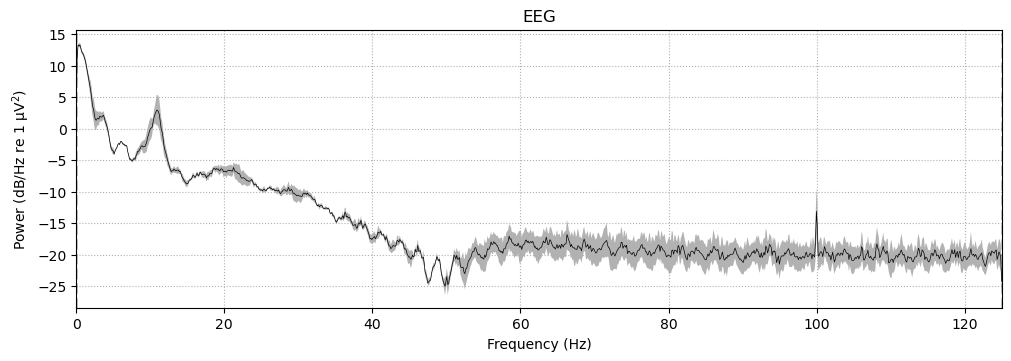

In [86]:
raw_0.compute_psd().plot(average=True, picks=[0,1,2]);

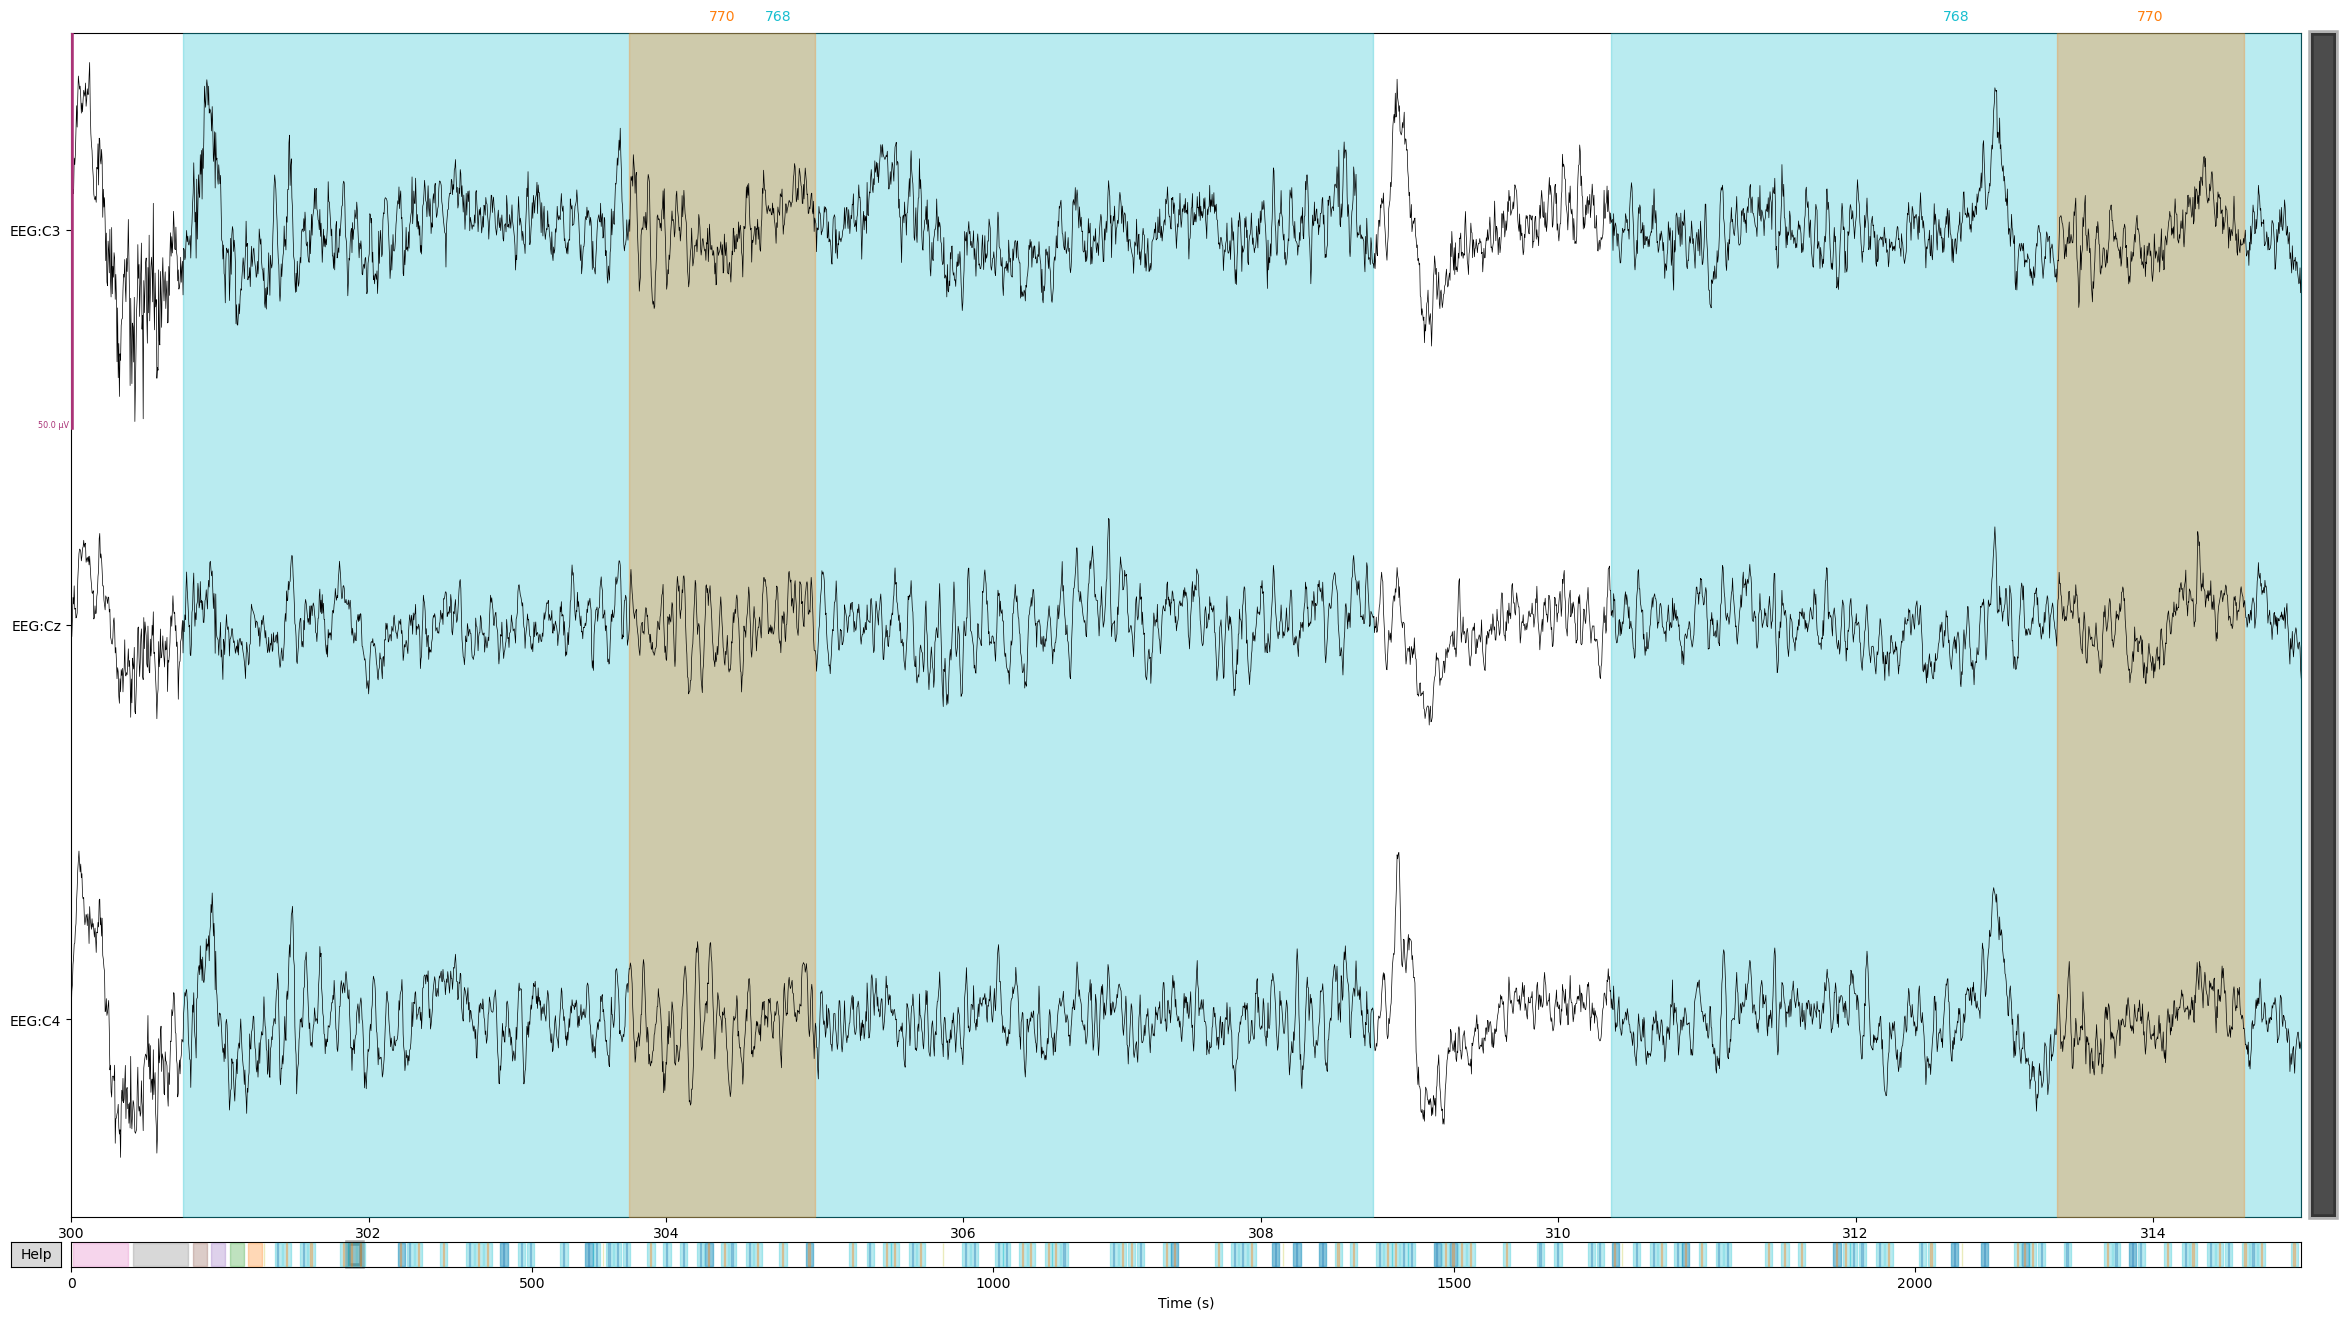

In [87]:
raw_0.plot(scalings=25e-6, duration=15.0, start=300);

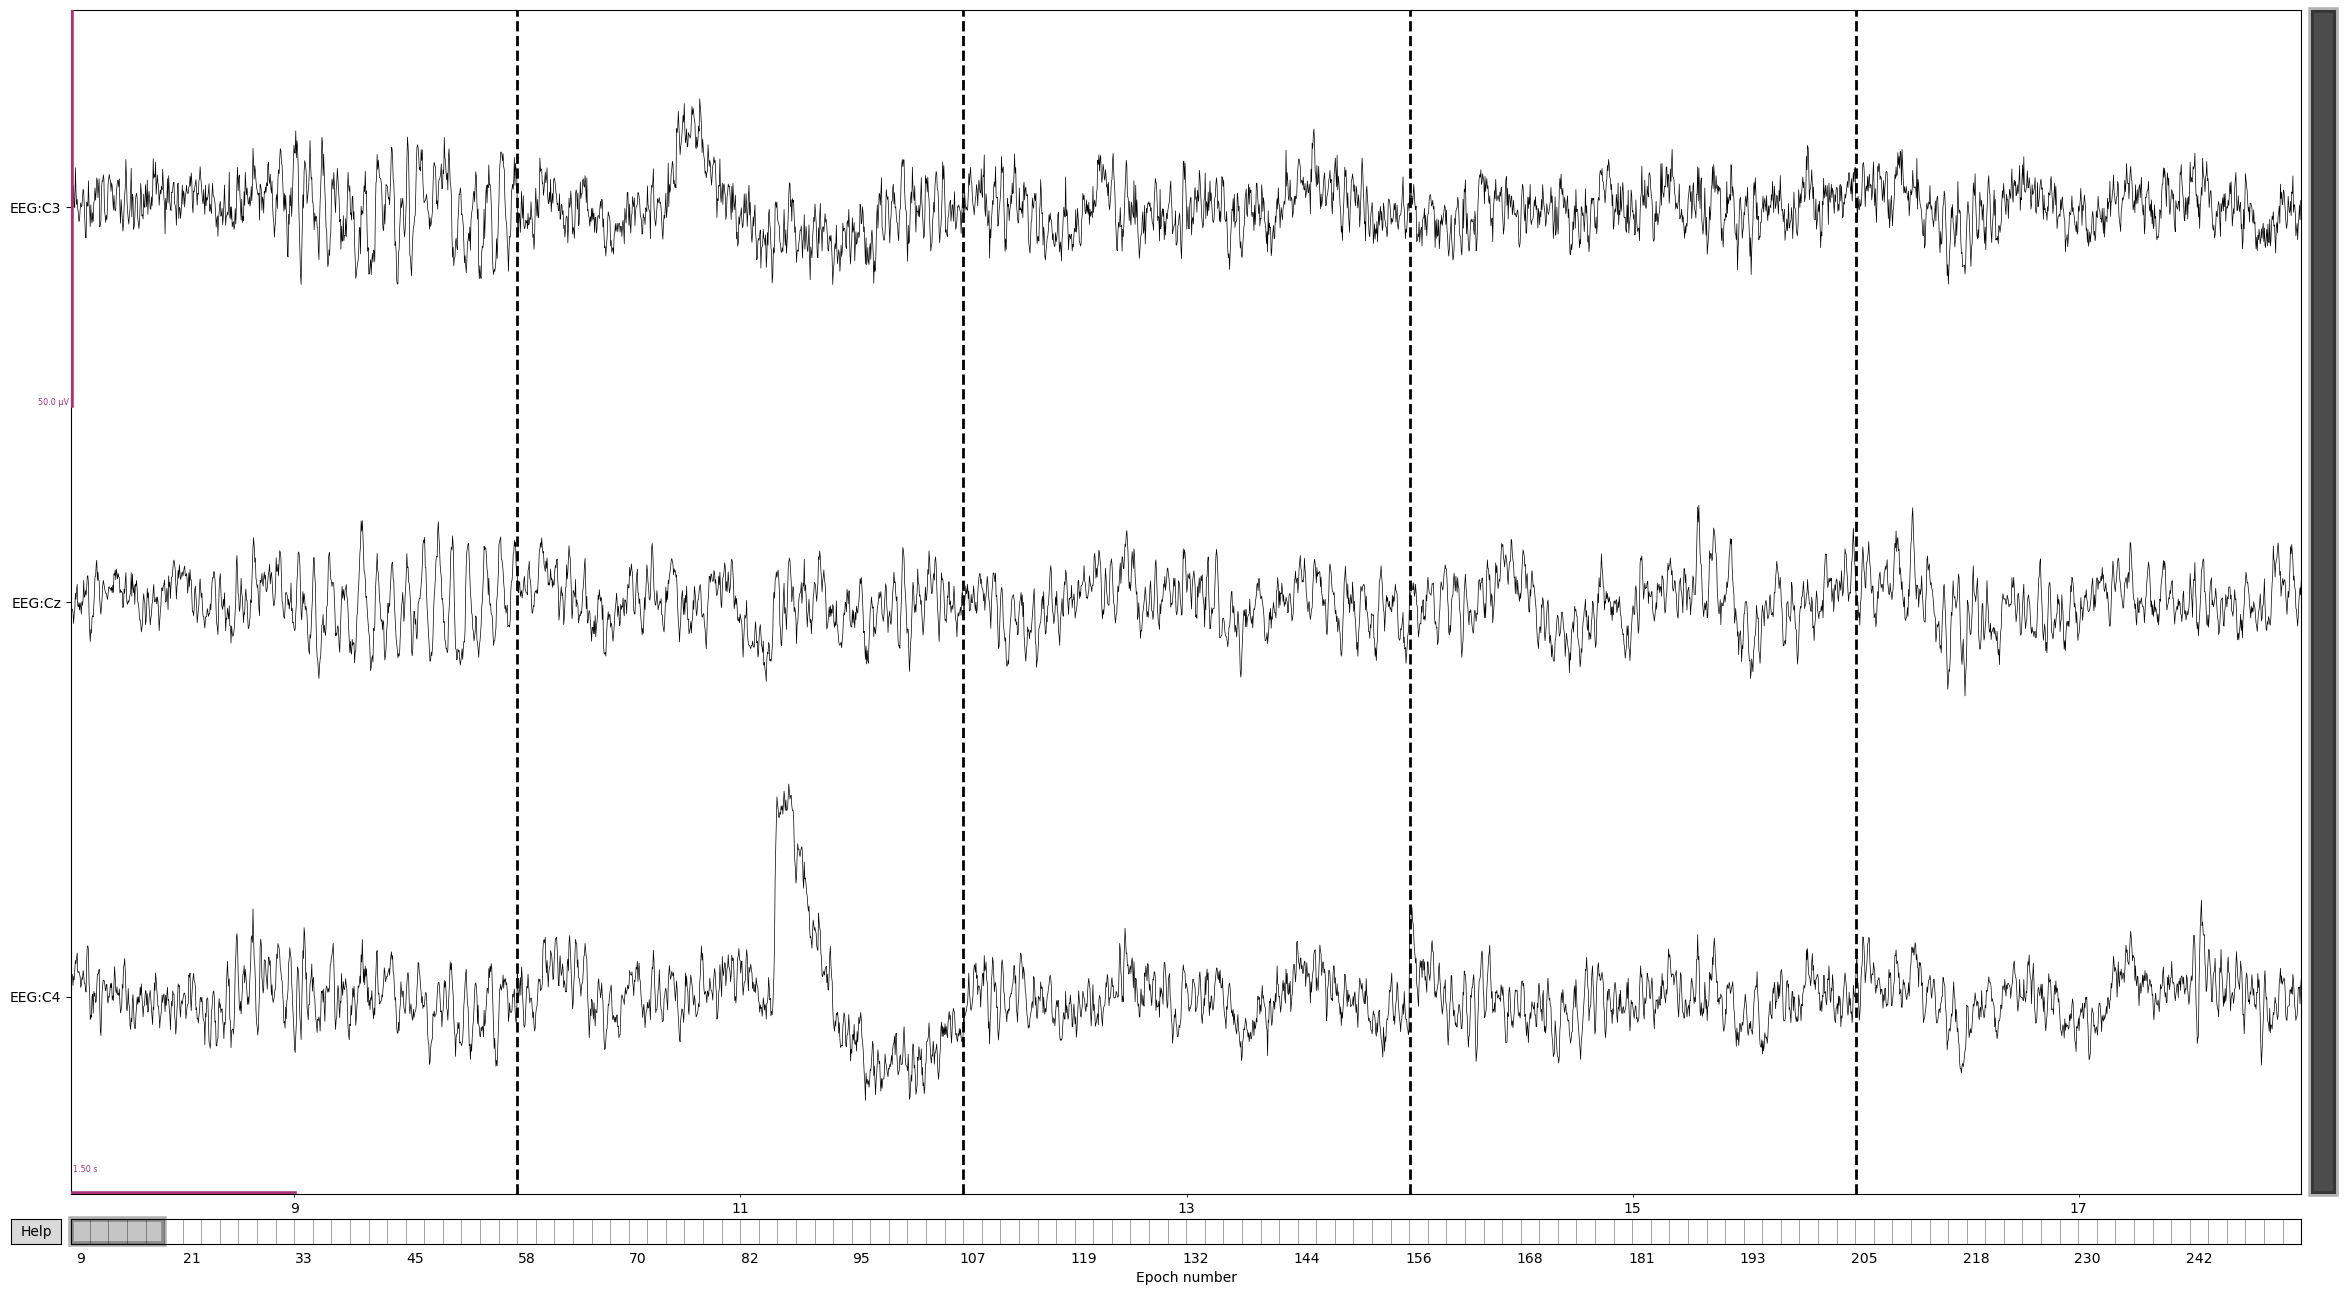

In [88]:
epochs_0.plot(scalings=25e-6, n_epochs=5, n_channels=6, title="All Trials");

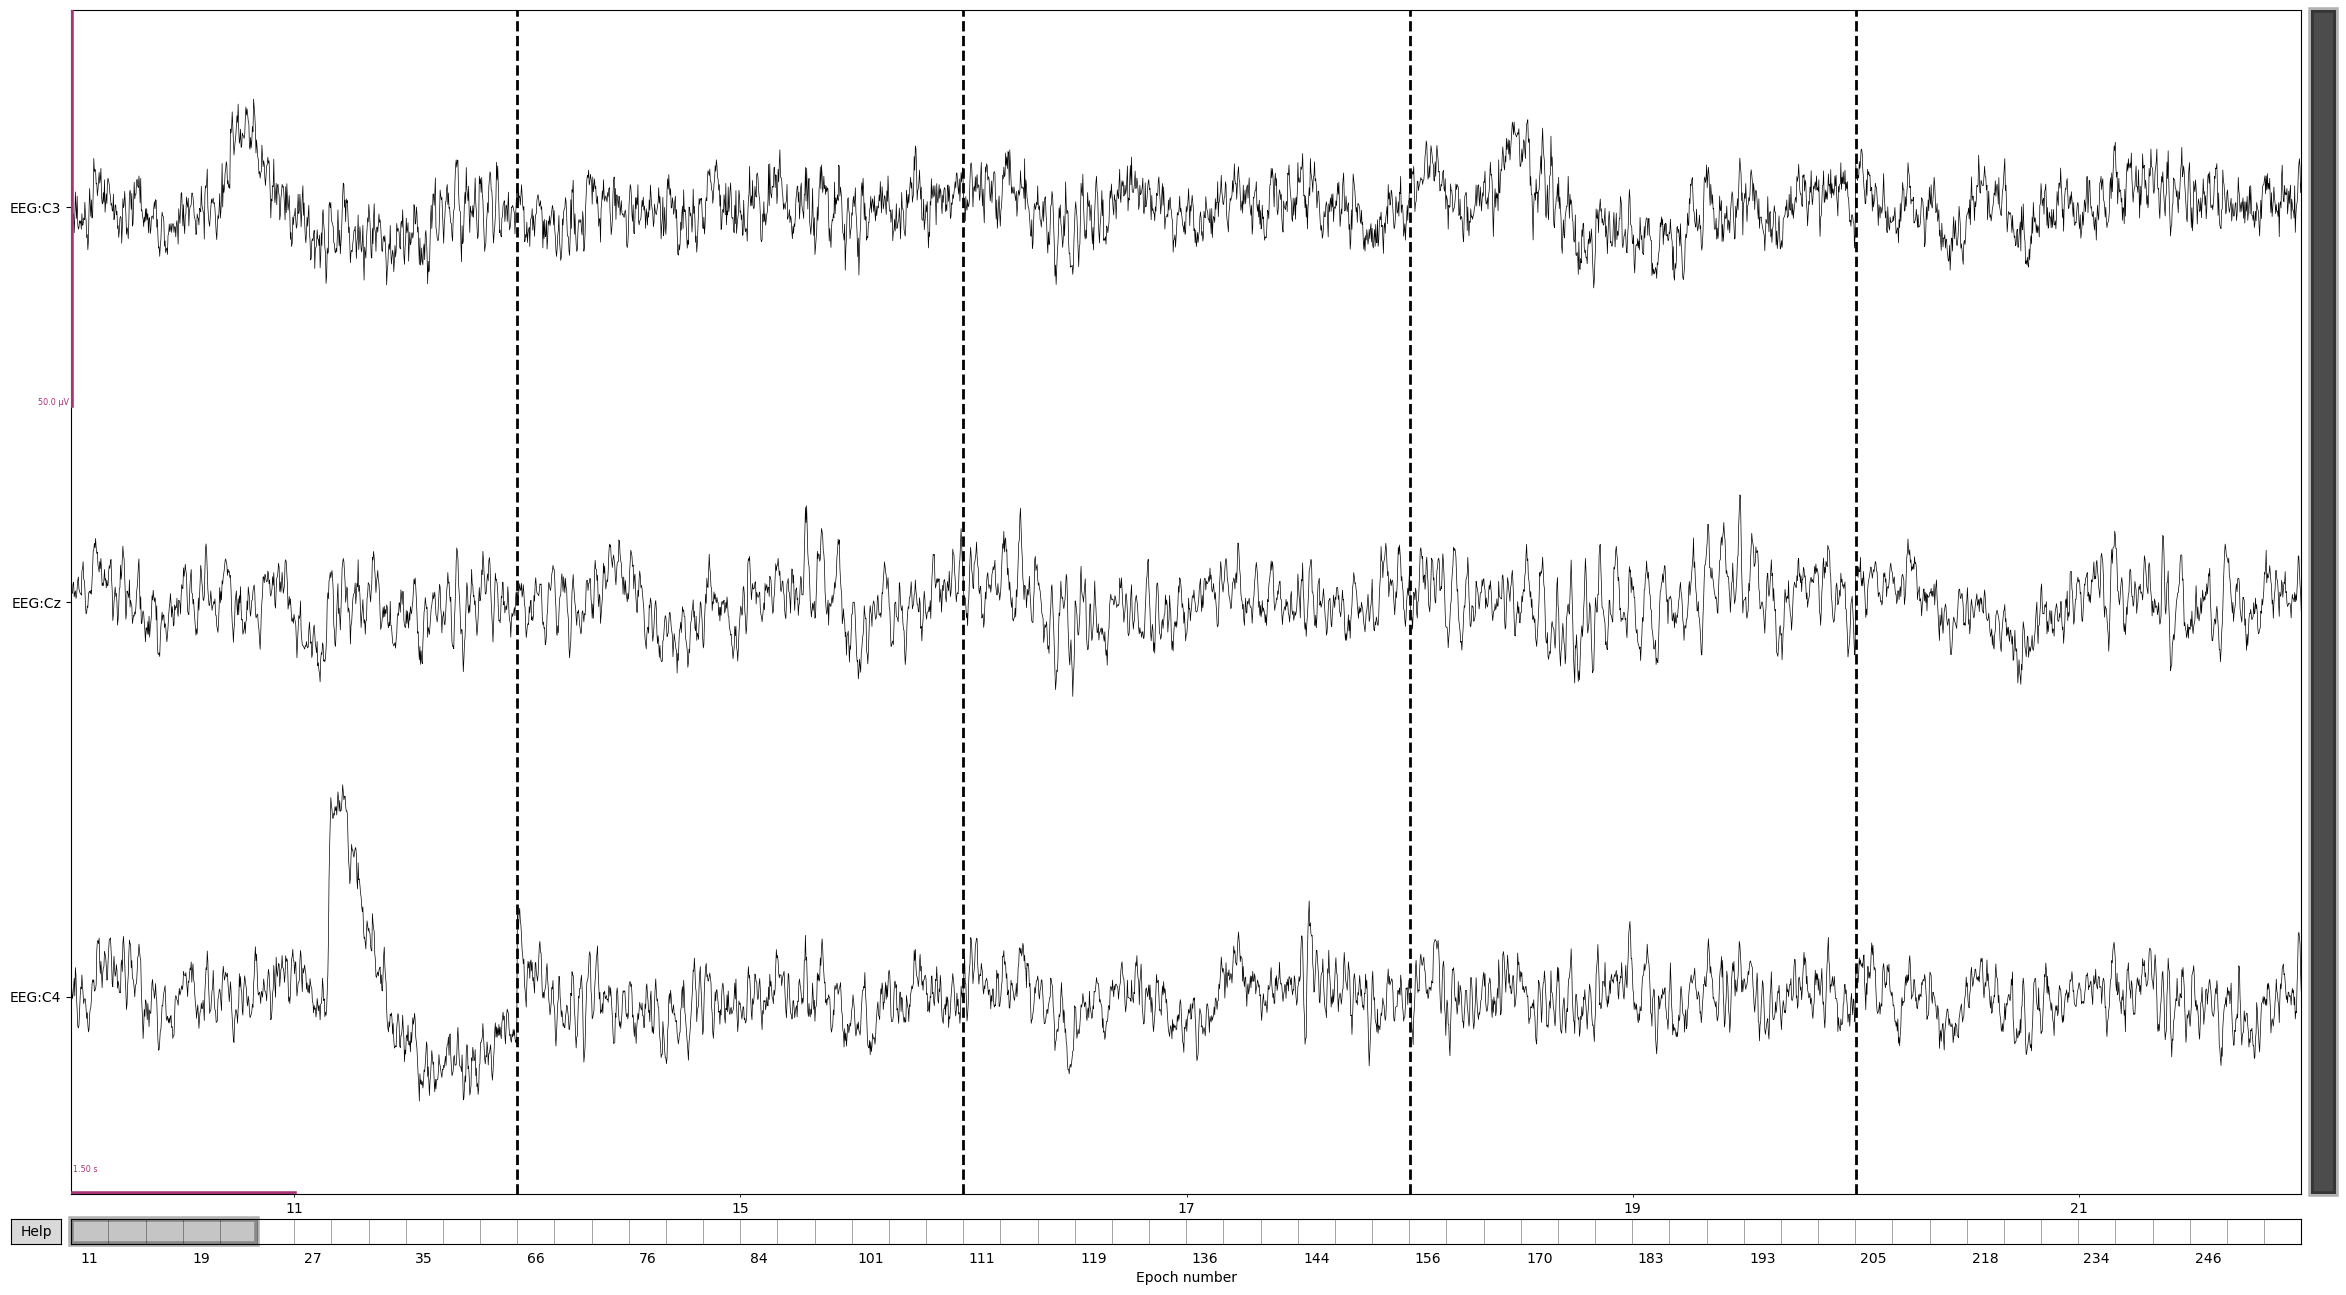

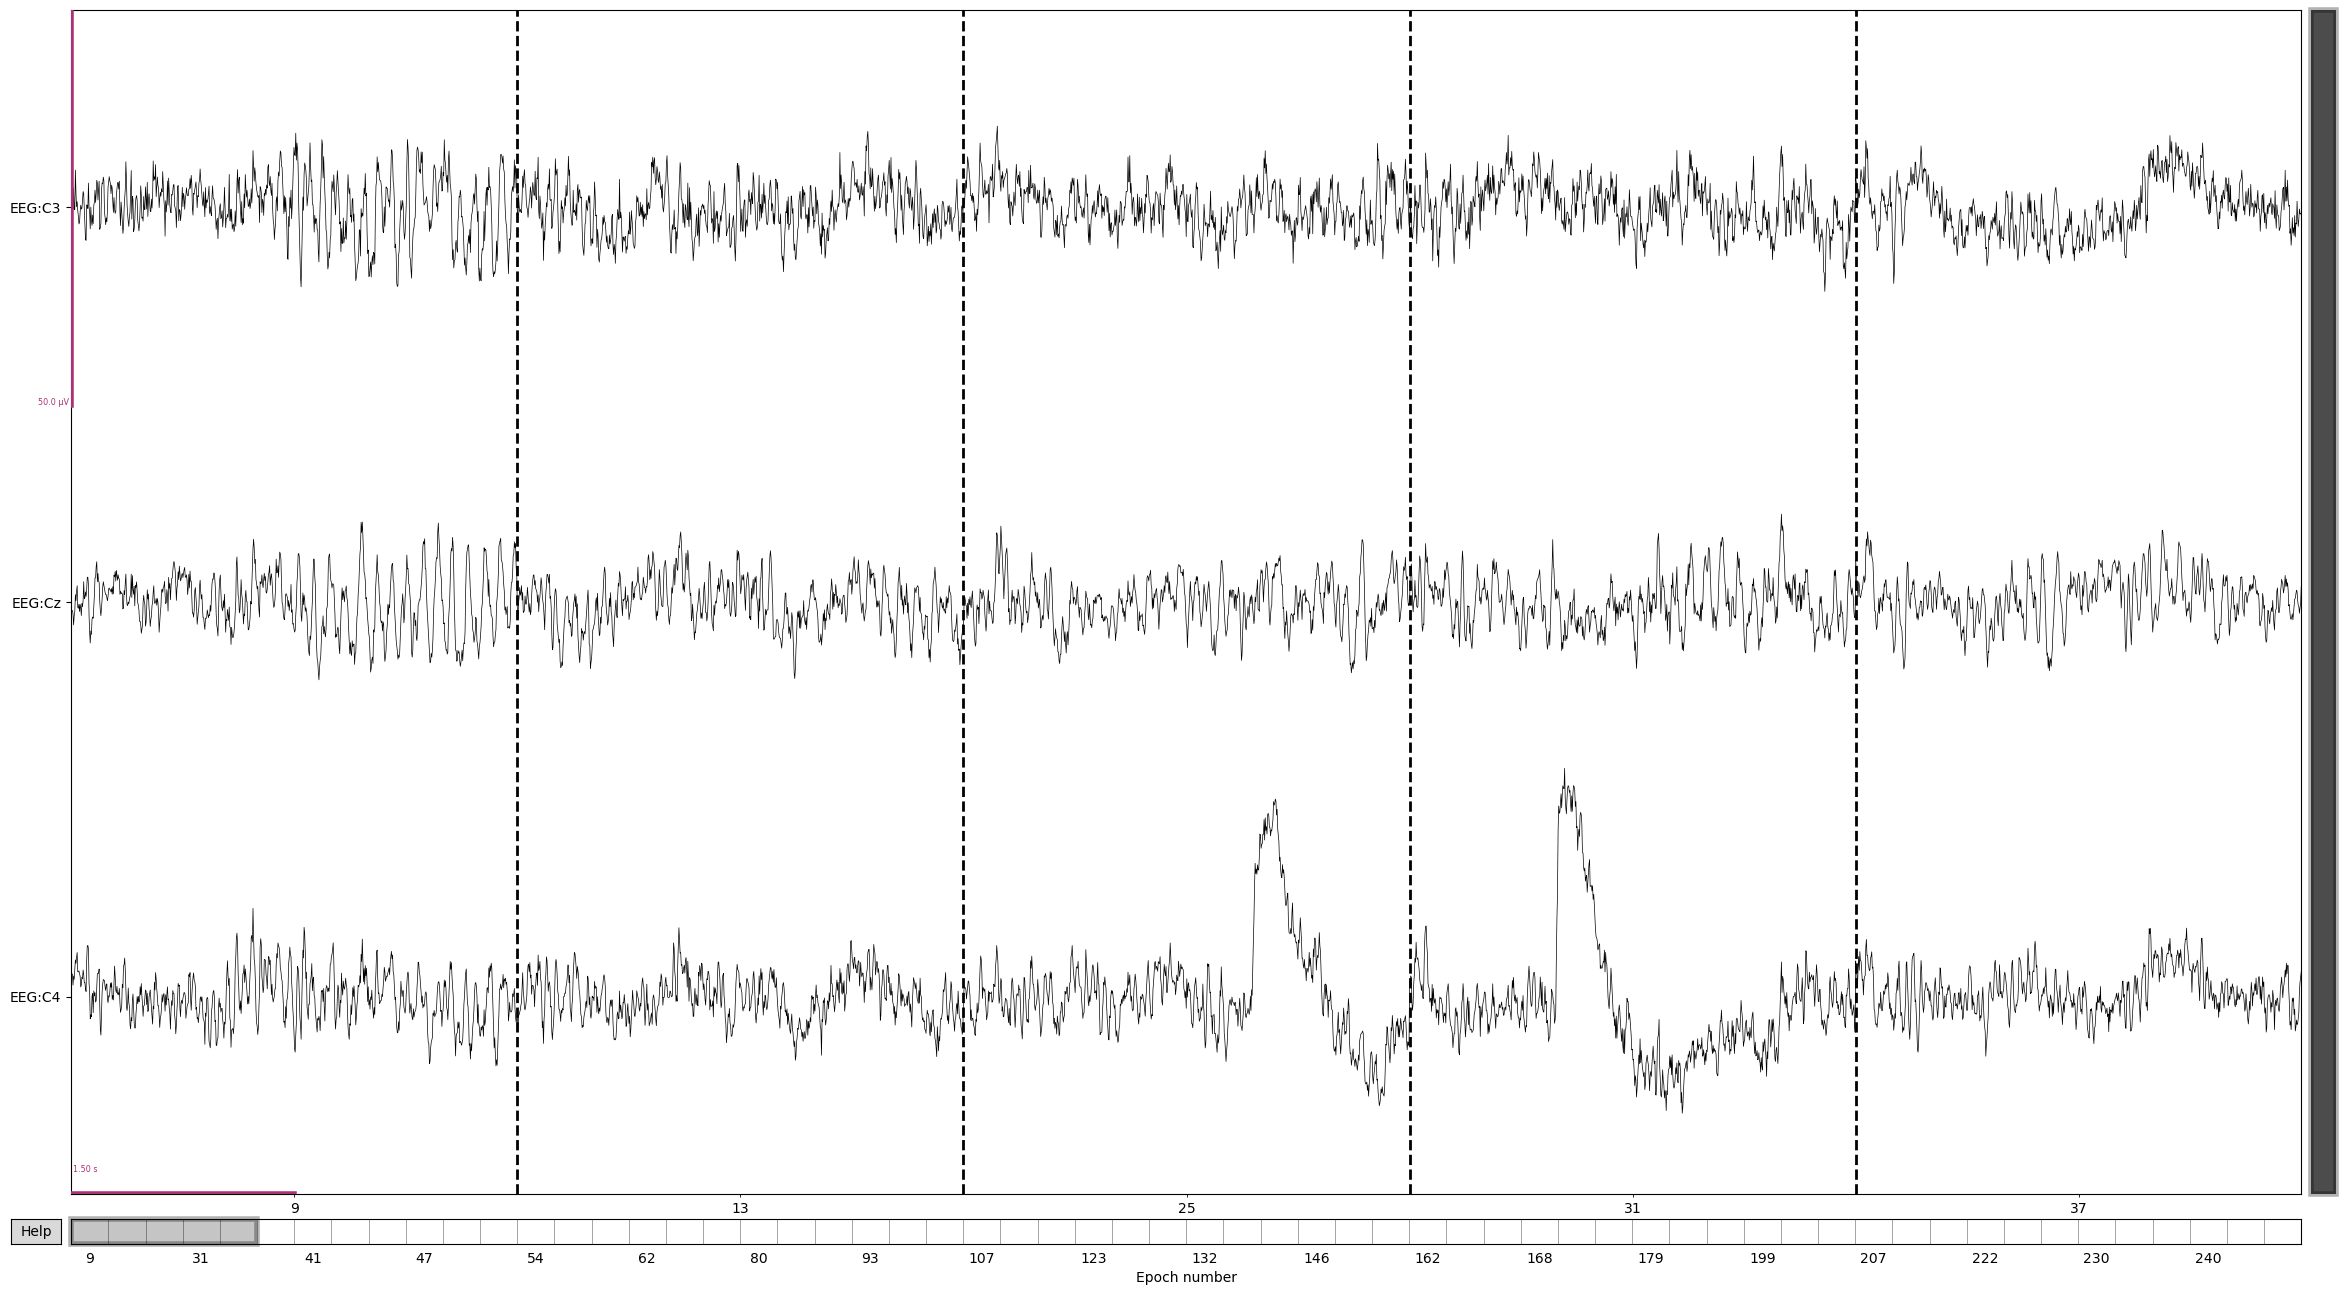

In [89]:

epochs_0["RH"].plot(scalings=25e-6, n_epochs=5, n_channels=3, title="RH Trials");
epochs_0["LH"].plot(scalings=25e-6, n_epochs=5, n_channels=3, title="LH Trials");

In [90]:
epochs_0.get_data()[0, :, 0]

array([-9.09437705e-07, -2.61844816e-06,  1.18715190e-06])

In [91]:
RESAMPLE_HZ = None
TMIN, TMAX = 1.0, 4.0 # in seconds based on the original paper
PICKS = [0, 1, 2] # only EEG channels
CODE_MAP = {"LH": "769", "RH": "770"}
FS = 250
FREQ_BANDS = {
    "delta": (0.5, 4.5),
    "theta": (4.5, 8.5),
    "alpha": (8.5, 11.5),
    "sigma": (11.5, 15.5), # often ignored, but let's keep it separate
    "beta": (15.5, 30),
    "gamma": (30, 45)
}

raws = load_gdf_files(DATA_DIR, picks=PICKS, resample_hz=RESAMPLE_HZ, mode="train") # in µV
X, y = make_dataset(raws, TMIN, TMAX,)
print("Dataset shape:", X.shape)

CHANNELS = X.shape[1]
SEQ_LEN  = X.shape[2]
print("CHANNELS:", CHANNELS, "SEQ_LEN:", SEQ_LEN)
print("Left:", (y == 0).sum())
print("Right:", (y == 1).sum())
# assert SEQ_LEN % 16 == 0

TypeError: make_dataset() missing 1 required positional argument: 'event_id'

In [ ]:
# raw_filt = raw.copy().filter(
#     l_freq=8.0,
#     h_freq=30.0,
#     method="iir",                 # IIR filter
#     iir_params=dict(order=4, ftype="butter"),  # Butterworth, 4th order
#     picks="eeg",                  # band-pass only EEG channels
#     verbose=True
# )

# # NEED REVIEW


NameError: name 'raw' is not defined

In [ ]:
plot_trials(X, fs=FS, n_show=3)

NameError: name 'X' is not defined

In [ ]:
X = crop_to(X, denominator=16)

Cropping SEQ_LEN from 876 -> 864 to satisfy architecture constraint.


In [ ]:
def print_stats_y(y: np.ndarray):
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    mean_y = np.mean(y)
    
    print("Mean of y:", mean_y)
    print("Class distribution:", class_counts)

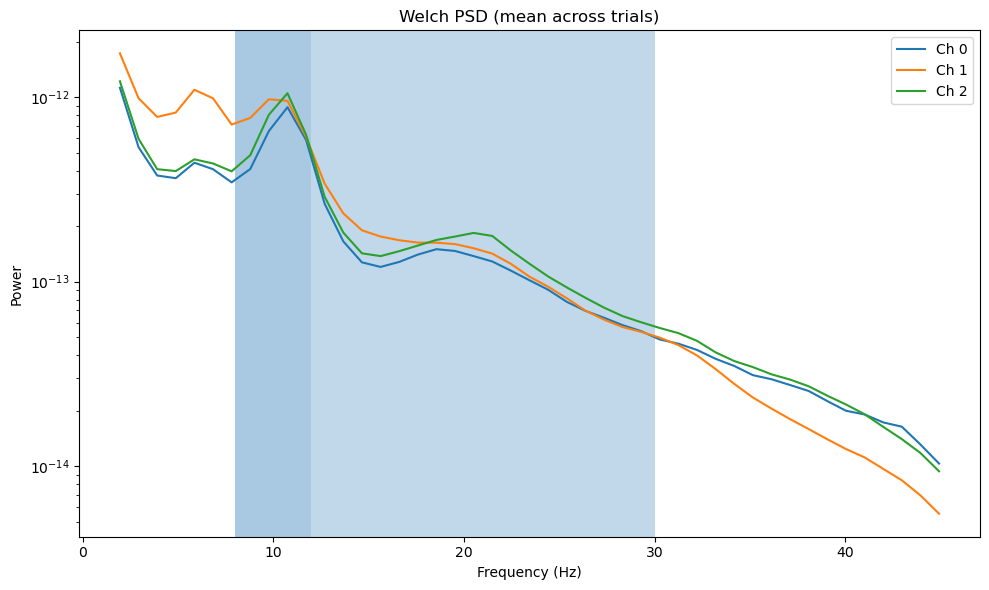

In [ ]:
plot_psd_welch(X, fs=raw.info['sfreq'], fmin=1, fmax=45, nperseg=256, n_show_channels=3)

- ERD ERS plot
- HGD pshionet
- NIquit frency

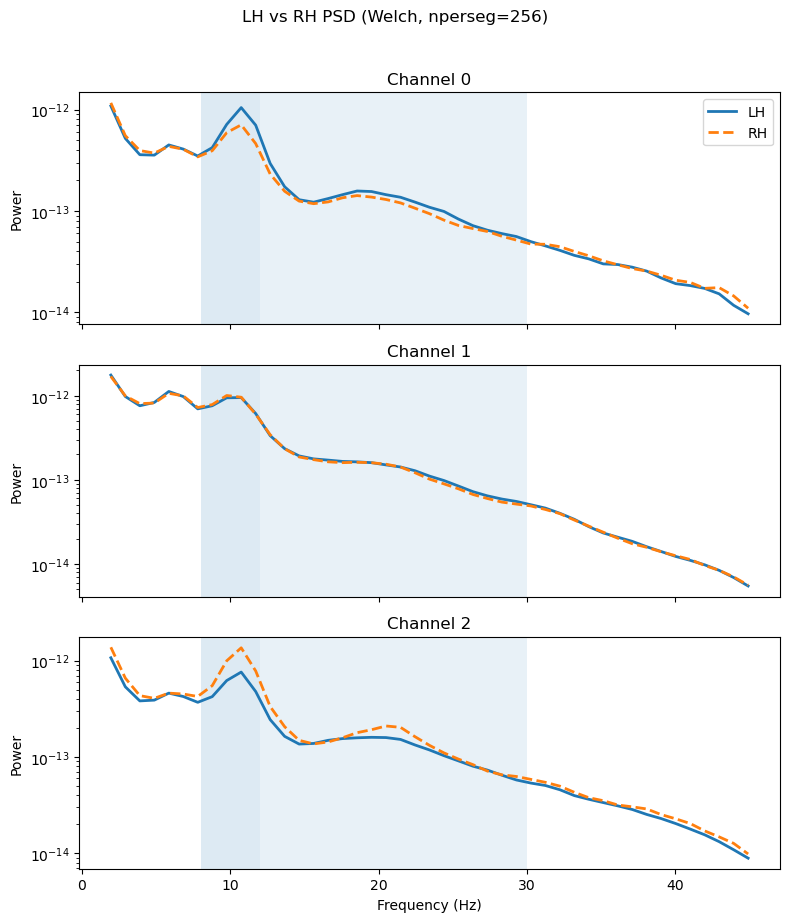

In [ ]:
plot_psd_lh_rh(X, y, fs=250, fmin=1, fmax=45, nperseg=256)

/var/folders/g5/m8q22yr95qb29lq55z_6_d7r0000gn/T/ipykernel_48743/4265942544.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(pxx[mask], f[mask])


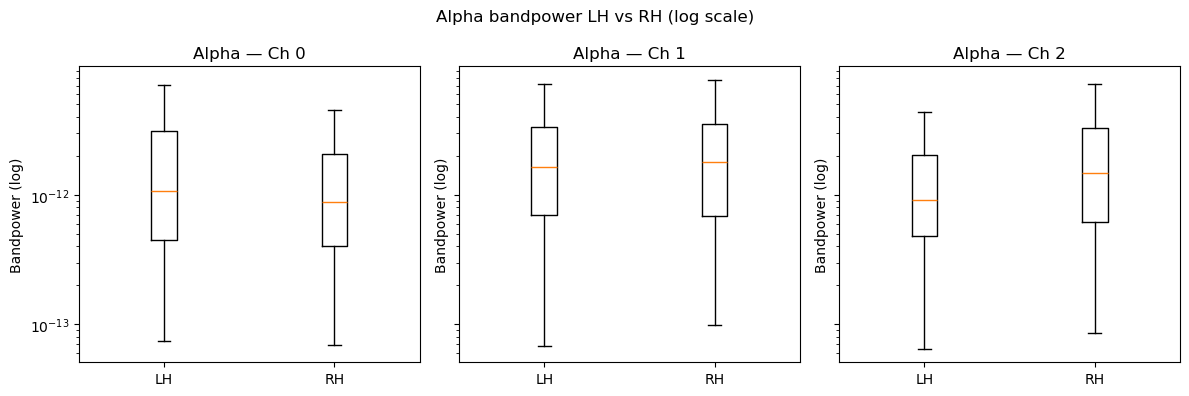

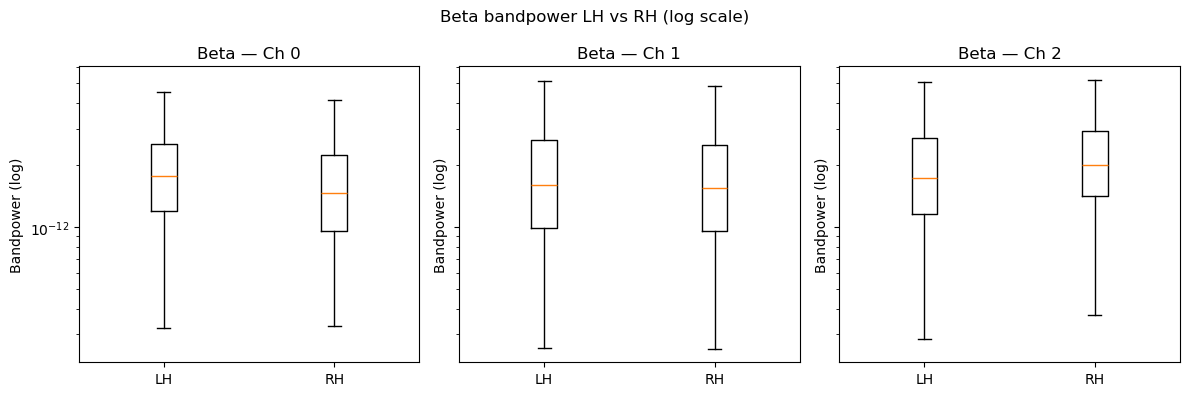

In [ ]:
bands = {
    "alpha": (8, 12),
    "beta": (12, 30),
}

bp = compute_bandpowers(X, fs=250, bands=bands)

plot_bandpower_boxplots(bp, y, "alpha") # Primary motor-imagery marker.
plot_bandpower_boxplots(bp, y, "beta") # Secondary motor-imagery marker.

In [ ]:
compute_effect_sizes(bp, y)


ALPHA BAND:
Channel 0: d = 0.230
Channel 1: d = -0.026
Channel 2: d = -0.339

BETA BAND:
Channel 0: d = 0.132
Channel 1: d = 0.027
Channel 2: d = -0.201


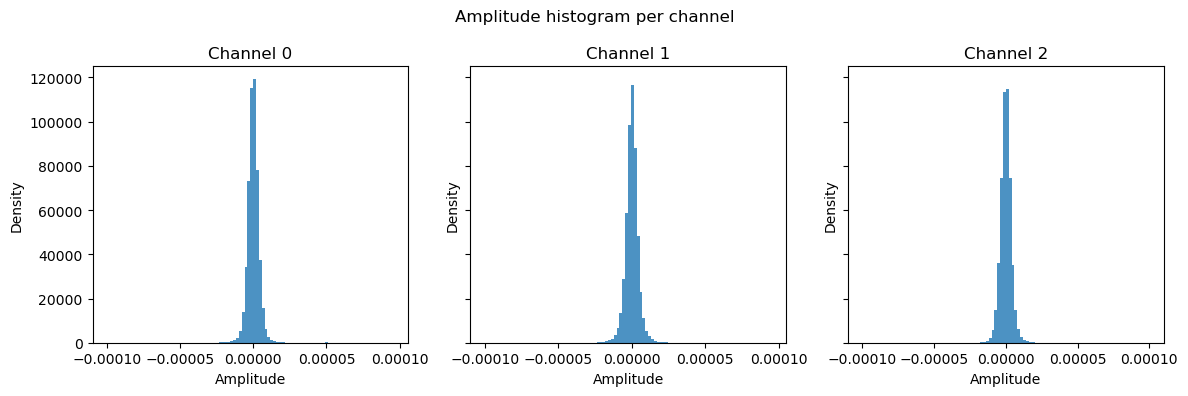

In [ ]:
# for selecting normalization strategy
# - If one channel is MUCH wider → normalize per channel.
# - If all channels are similar → normalize globally.
plot_hist_per_channel(X) # Plot amplitude histograms per channel

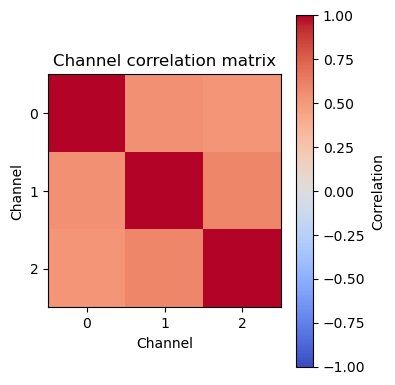

Correlation matrix:
 [[1.         0.54307074 0.51735495]
 [0.54307074 1.         0.58557717]
 [0.51735495 0.58557717 1.        ]]


In [ ]:
plot_channel_correlation(X)

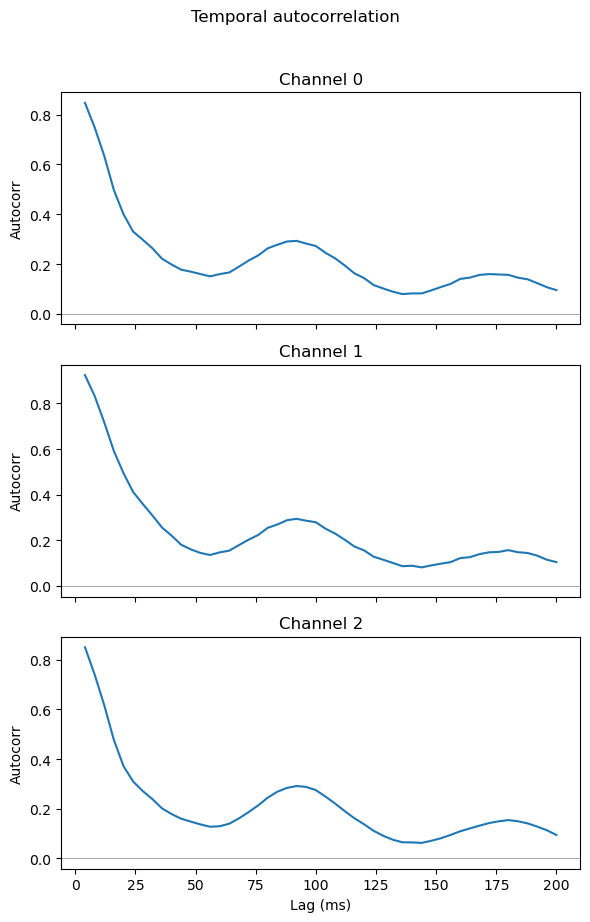

(<Figure size 600x900 with 3 Axes>,
 array([<Axes: title={'center': 'Channel 0'}, ylabel='Autocorr'>,
        <Axes: title={'center': 'Channel 1'}, ylabel='Autocorr'>,
        <Axes: title={'center': 'Channel 2'}, xlabel='Lag (ms)', ylabel='Autocorr'>],
       dtype=object))

In [ ]:
plot_temporal_autocorr(X, fs=250, max_lag_ms=200) # ~2 alpha cycles(~10 Hz),  ~4 beta cycles(~20 Hz)

In [ ]:
# Before normalization
print("Before normalization(in µV):")
print("-" * 20)
print_stats_X(X)

Before normalization(in µV):
--------------------
Shape: (3680, 3, 864)
NaNs: 0
Infs: 0
Min val: -0.000100001525
Max val: 9.999848e-05

Per-channel std across (trials,time):
Min: 4.01301e-06
Median: 4.224297e-06
Max: 4.39843e-06
Channels with std < 1e-7: 0
Channels with std < 1e-8: 0

Per-trial-per-channel std over time:
Min: 1.3871206e-06
Median: 3.3151637e-06
Max: 3.608946e-05

Per-channel mean across (trials,time):
Min: 2.4531877e-08
Median: 3.1454146e-08
Max: 8.67186e-08

Per-trial-per-channel mean over time:
Min: -1.1805245e-05
Median: 4.2140243e-08
Max: 1.5339196e-05


In [ ]:
ESP = 1e-8
Xn = X.copy()
mean, std = fit_global_channel_zscore(X, eps=ESP)
Xn = apply_zscore(X, mean, std)

print("After normalization:")
print("-" * 20)
print_stats_X(Xn)

After normalization:
--------------------
Shape: (3680, 3, 864)
NaNs: 0
Infs: 0
Min val: -24.86349
Max val: 24.850534

Per-channel std across (trials,time):
Min: 0.9975154
Median: 0.9976383
Max: 0.99773204
Channels with std < 1e-7: 0
Channels with std < 1e-8: 0

Per-trial-per-channel std over time:
Min: 0.31465185
Median: 0.78184867
Max: 8.970761

Per-channel mean across (trials,time):
Min: -1.5106322e-08
Median: 1.6736812e-09
Max: 8.334212e-09

Per-trial-per-channel mean over time:
Min: -2.7954345
Median: -0.00047049037
Max: 3.8067677


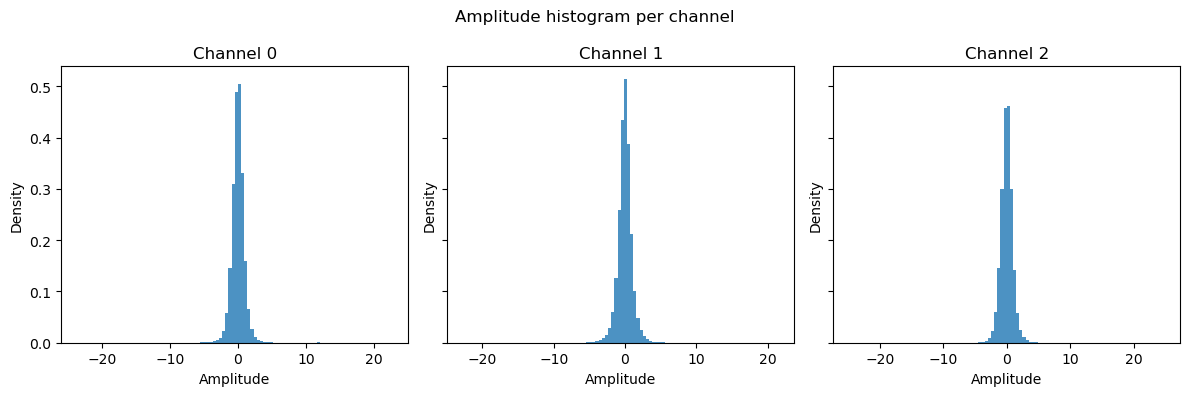

In [ ]:
plot_hist_per_channel(Xn)

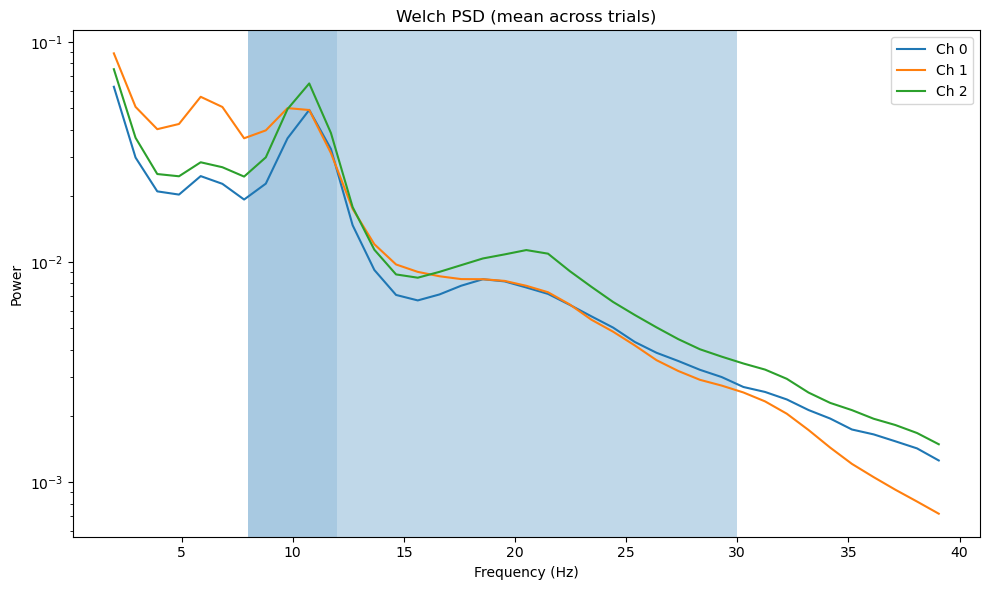

In [ ]:
plot_psd_welch(Xn, fs=250, fmin=1, fmax=40)

/var/folders/g5/m8q22yr95qb29lq55z_6_d7r0000gn/T/ipykernel_48743/4265942544.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(pxx[mask], f[mask])


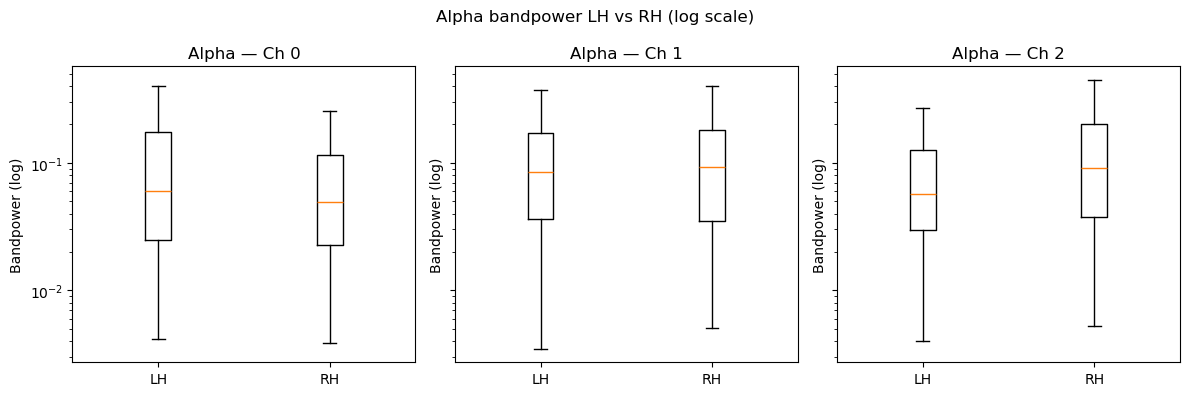

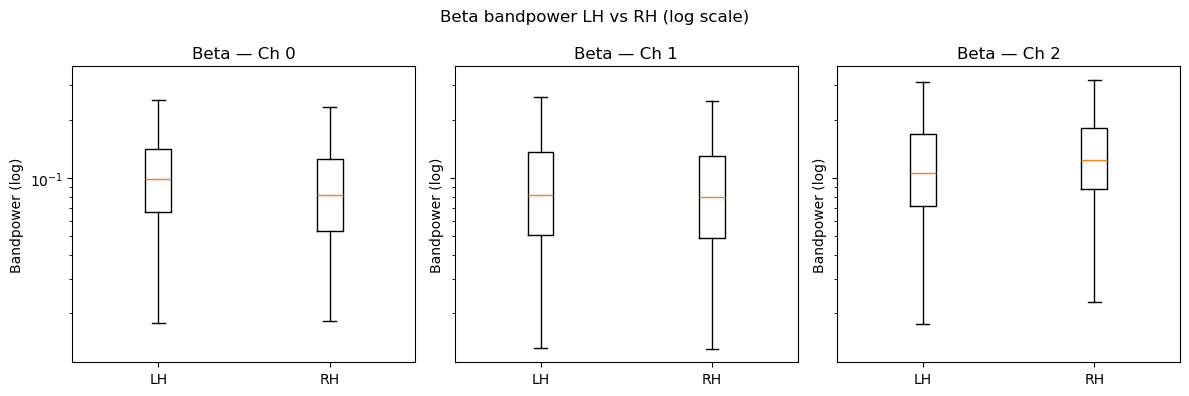


ALPHA BAND:
Channel 0: d = 0.230
Channel 1: d = -0.026
Channel 2: d = -0.339

BETA BAND:
Channel 0: d = 0.132
Channel 1: d = 0.027
Channel 2: d = -0.201


In [ ]:
bp_n = compute_bandpowers(Xn, fs, bands)
plot_bandpower_boxplots(bp_n, y, "alpha")
plot_bandpower_boxplots(bp_n, y, "beta")
compute_effect_sizes(bp_n, y)

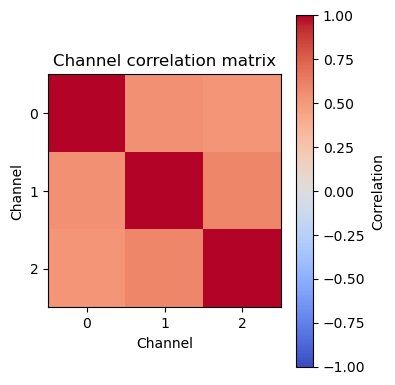

Correlation matrix:
 [[1.         0.54307074 0.51735495]
 [0.54307074 1.         0.58557717]
 [0.51735495 0.58557717 1.        ]]


In [ ]:
plot_channel_correlation(Xn)

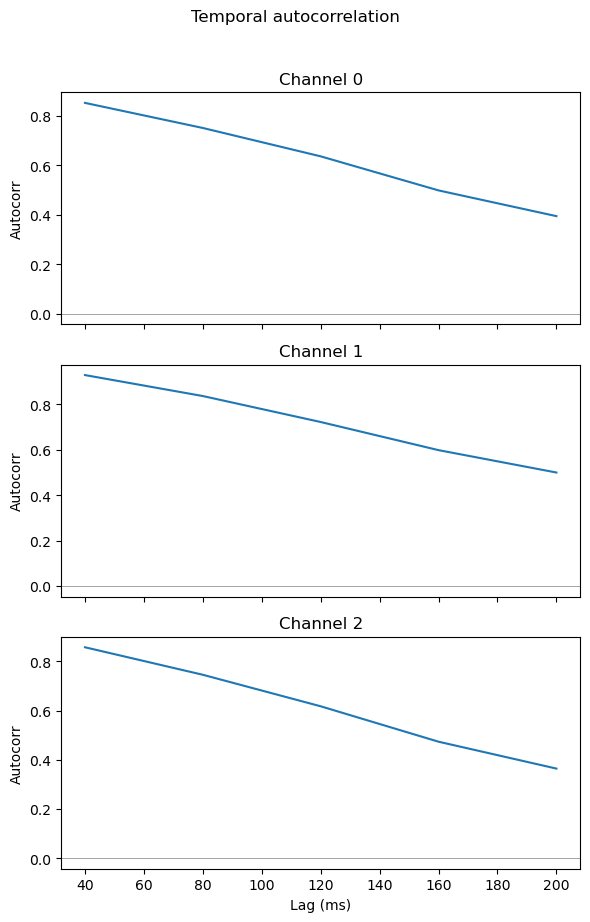

In [ ]:
fig_autocorr2, ax2 = plot_temporal_autocorr(Xn, fs=25, max_lag_ms=200)

In [ ]:
trial_std = Xn.std(axis=2)          # (trials, channels)
print("std over time, mean per channel:", trial_std.mean(axis=0))
print("std over time, std per channel :", trial_std.std(axis=0))

std over time, mean per channel: [0.84797007 0.8985561  0.9015367 ]
std over time, std per channel : [0.48690173 0.41989622 0.3948742 ]
